In [11]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import time

In [12]:
randm_state = 123123

In [13]:
train = pd.read_csv('../data/train.csv')
test= pd.read_csv('../data/test.csv')


In [14]:
train.replace([-9999,-9999.0,'-9999','-9999.0'],np.nan,inplace=True)
test.replace([-9999,-9999.0,'-9999','-9999.0'],np.nan,inplace=True)
#data=train.append(test).reset_index(drop=True)
data=train

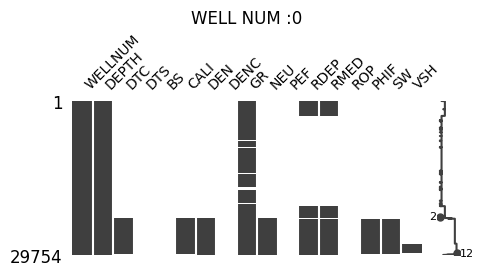

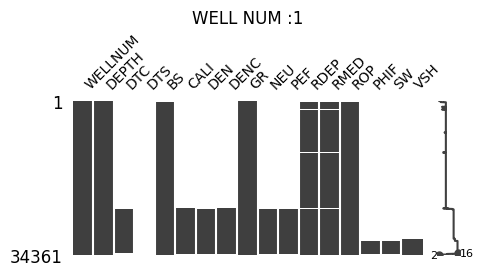

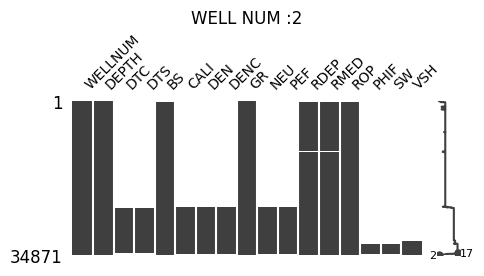

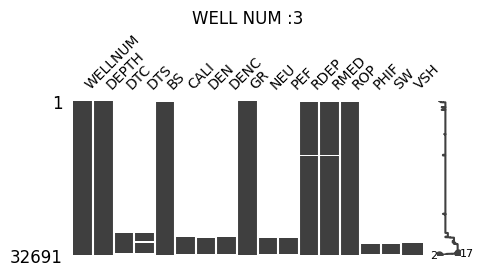

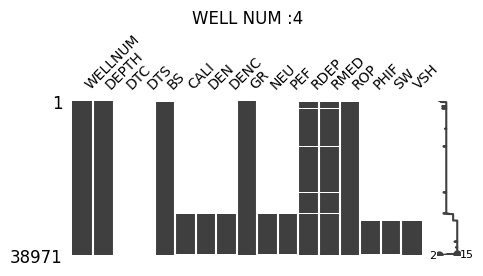

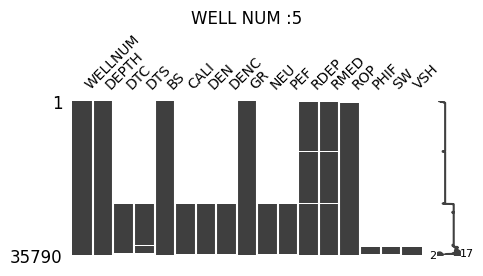

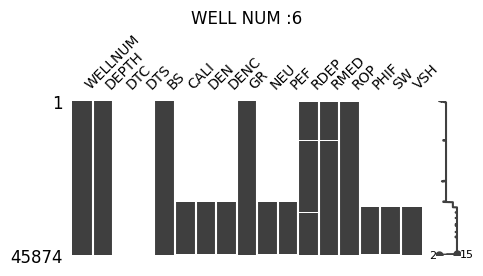

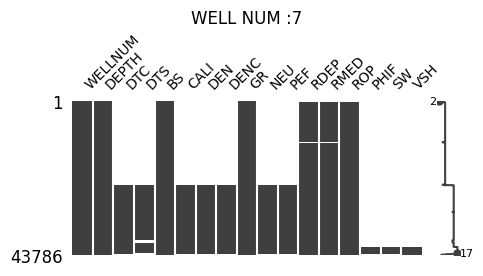

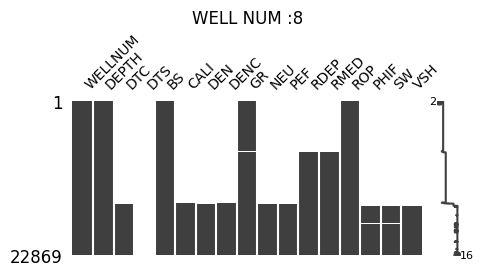

In [15]:
for i in data.WELLNUM.unique():
    ax=msno.matrix(data[data['WELLNUM']==i].reset_index(drop=True), figsize=(5,2), fontsize=10)
    ax.set_title('WELL NUM :'+str(i))


## Comments
- CALI is needed to assure the hole conditions are accounted for , only data with CALI will be used for training and imputation!

In [10]:
data = data.dropna(subset=['CALI']).reset_index(drop=True)

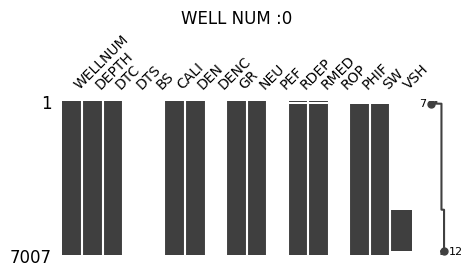

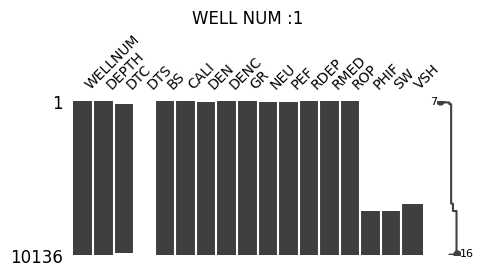

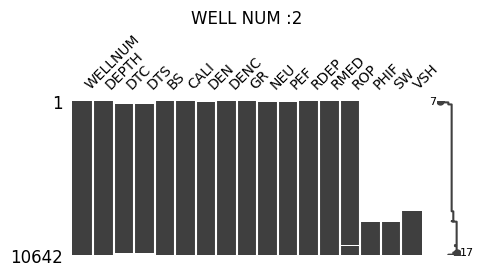

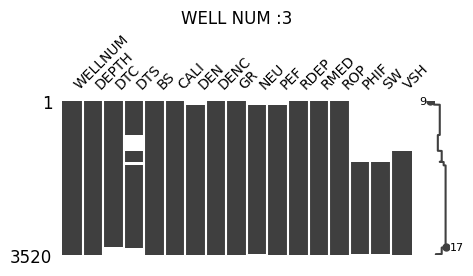

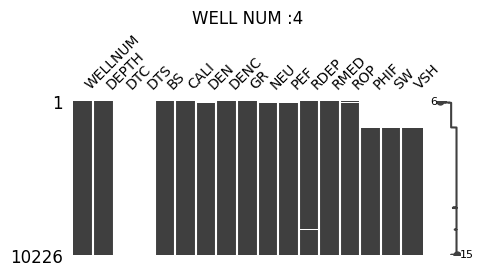

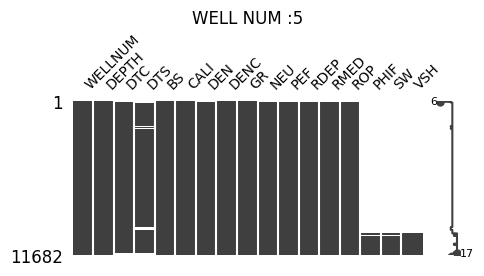

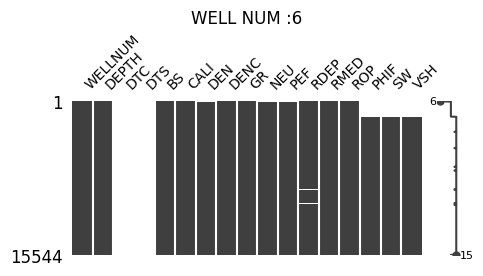

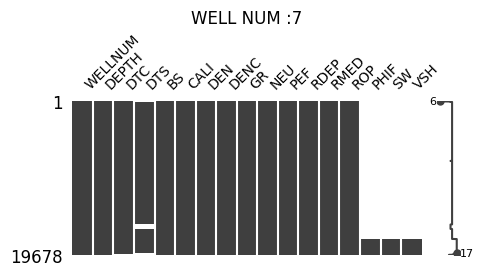

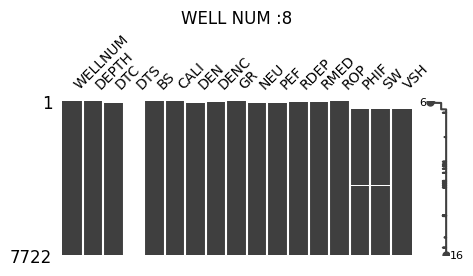

In [9]:
for i in data.WELLNUM.unique():
    ax=msno.matrix(data[data['WELLNUM']==i].reset_index(drop=True), figsize=(5,2), fontsize=10)
    ax.set_title('WELL NUM :'+str(i))


In [16]:
data['log10ild']=np.log10(train.RDEP)
data['log10ilm']=np.log10(train.RMED)

In [17]:
train.BS.value_counts()

BS
8.50     90482
26.00    87569
17.50    85270
12.25    24007
36.00      585
Name: count, dtype: int64

## imputing missing logs

In [18]:
#not all wells have Bit size
data_BS_train = data.dropna(subset=['BS']).reset_index(drop=True)
data_BS_train['BS']=data_BS_train['BS'].astype(str)

In [28]:
#incase not installed
#!pip install pycaret[full]
from pycaret.classification import *

ModuleNotFoundError: No module named 'pycaret'

In [24]:
setup(data = data_BS_train,target = 'BS',ignore_features=['WELLNUM','VSH','SW','PHIF'],session_id=randm_state,silent=True)

NameError: name 'setup' is not defined

In [14]:
data.BS.value_counts()

8.50     99811
12.25      416
17.50      198
Name: BS, dtype: int64

In [15]:
BS_model = finalize_model('rf')

In [16]:
data = predict_model(BS_model,data)

In [17]:
data['BS'].fillna(data['Label'],inplace=True)

In [18]:
data.drop(columns=['Label','Score'],inplace=True)

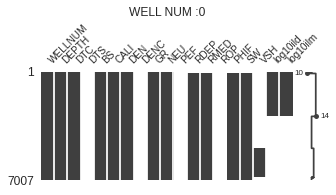

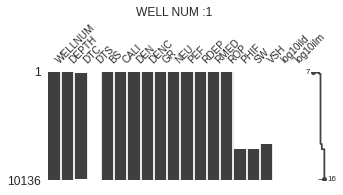

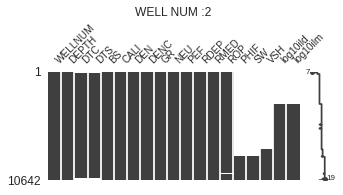

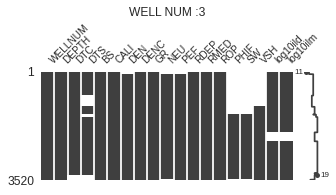

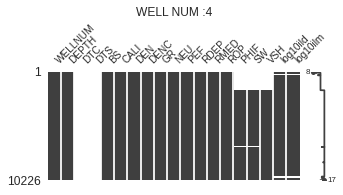

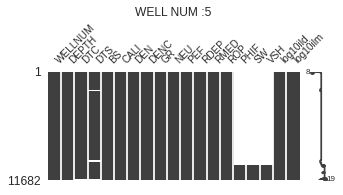

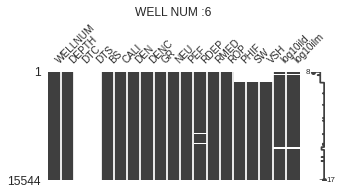

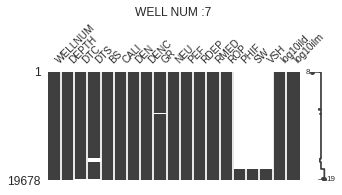

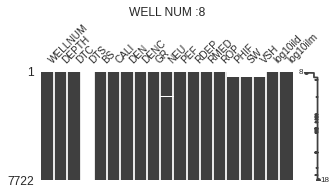

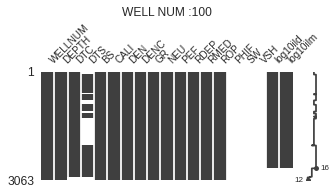

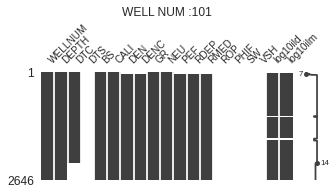

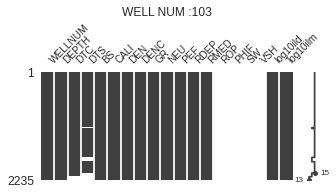

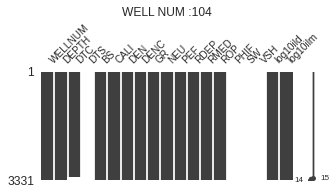

In [19]:
for i in data.WELLNUM.unique():
    ax=msno.matrix(data[data['WELLNUM']==i].reset_index(drop=True), figsize=(5,2), fontsize=10)
    ax.set_title('WELL NUM :'+str(i))

In [20]:
from pycaret.regression import *

In [21]:
#pass GR as target , let iterative imputer use xgboost model to preidct missing logs session_id=randm_state
setup(data = data,target = 'GR',categorical_features=['BS'],ignore_features=['WELLNUM','VSH','SW','PHIF'],session_id=randm_state,imputation_type='iterative',numeric_iterative_imputer='xgboost',use_gpu=True,silent=True)

,Description,Value
0,session_id,123123
1,Target,GR
2,Original Data,"(107432, 19)"
3,Missing Values,1
4,Numeric Features,13
5,Categorical Features,1
6,Ordinal Features,0
7,High Cardinality Features,0
8,High Cardinality Method,None
9,Transformed Train Set,"(75195, 16)"


(False,
 'GR',
 Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['BS'],
                                       display_types=False,
                                       features_todrop=['WELLNUM', 'VSH', 'SW',
                                                        'PHIF'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='GR',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boosting_type='gbdt',
                                                              class_weig...
                 ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                 ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                 ('cluster_all', 'passthrough'), (

In [22]:
get_config('X').columns

Index(['DEPTH', 'DTC', 'DTS', 'CALI', 'DEN', 'DENC', 'NEU', 'PEF', 'RDEP',
       'RMED', 'ROP', 'log10ild', 'log10ilm', 'BS_12.25', 'BS_17.5', 'BS_8.5'],
      dtype='object')

In [23]:
columns = ['DTC', 'DTS', 'CALI', 'DEN', 'DENC', 'NEU', 'PEF', 'RDEP',
       'RMED', 'ROP', 'log10ild', 'log10ilm']

In [24]:
data[columns]=data[columns].fillna(get_config('X')[columns])

In [25]:
data.to_csv('data_imputed.csv',index=False)

In [26]:
#now modeling starts . if imputation is done , load data csv

In [27]:
#clean data already imputed
randm_state = 123123
data = pd.read_csv('data_imputed.csv')

print ('all wells in data :',list(data.WELLNUM.unique()))

all wells in data : [0, 1, 2, 3, 4, 5, 6, 7, 8, 100, 101, 103, 104]


In [28]:
##feature engineering functions

import numpy as np
import matplotlib.pyplot as plt

# #petrophysical calculations 
# from https://github.com/whamlyn/auralib/blob/01d64e25018fa249b3f901700428e9cb211d803c/auralib/pp.py
def calc_Rw(Tc, Wse, verbose=False):
    """
    Tc = 60.0       # Temperature (Celcius)
    Wse =  60000.0  # Salinity (ppm)
    """
    
    # 1) Convert from Celcius to Farenheit
    Tf = 9.0/5.0*Tc + 32.0
    
    # 2) Calculate Resistivity in Ohm meters
    Rw = (400000.0/(Tf*Wse))**0.88
    
    if verbose == True:
        print("T (C):     %10.2f" % (Tc))
        print("T (f):     %10.2f" % (Tf))
        print("Wse (ppm): %10.2f" % (Wse))
        print("Rw (Ohm*m):%10.5f" % (Rw))

    return Rw



def calc_Rw2(Tc, Wse, verbose=False):    
    """
    Uses method from textbook "Petrophysics" by Djebbar and Donaldson.
    
    Supposedly more accurate than the approach used in calc_Rw because Hx and 
    RwT account for non-linearlity in resistivity as a function of salinity.
    
    
    #  Input Parameters
    # -------------------
    
    Tc = 60.0       # Temperature (Celcius)
    Wse = 60000.0   # Salinity (ppm)
    """
    
    #  Calculations:
    
    # 1) Convert from Celcius to Farenheit
    Tf = 9.0/5.0*Tc + 32.0
    
    # 2) Calculate reference water resistivity @ 75 Degrees Farenheit
    Rw75 = 1.0/(2.74*10**-4 * Wse**0.955) + 0.0123
    
    # 3) Calculate nonlinear correction factors
    Xh = 10.0**(-0.3404*np.log10(Rw75) + 0.6414)
    
    # 4) Calculate Water Resistivity at Temperature T1.  Output is Ohm-m
    Rw = Rw75 * (75.0 + Xh)/(Tf + Xh)
    
    if verbose == True:
        print(" ")
        print("T (C):     %10.2f" % (Tc))
        print("T (f):     %10.2f" % (Tf))
        print("Wse (ppm): %10.2f" % (Wse))
        print("Rw (Ohm*m):%10.5f" % (Rw))
    
    return Rw
    
    

def sw_archie(res, phi, Rw, a=1.0, m=2.0, n=2.0):
    """
    Calculate water saturation using Archie method.
    
                (a * Rw)  
        Sw = ( ----------- )^(1/n)
               phi^m * res 
    
    
    Sw = sw_archie(res, phi, Rw, a, m, n)
    
    Sw = water saturation
    res = measured formation resistivity
    phi = effective porosity
    Rw = formation water resistivity
    a = constant
    m = constant
    n = constant
    
    """
    
#     Rw = float(Rw)
#     a = float(a)
#     m = float(m)
#     n = float(n)
    
    Sw = (a * Rw / (phi**m * res)) ** (1 / n)
    
    Sw[Sw < 0] = 0.0
    Sw[Sw > 1] = 1.0

    return Sw
    

def sw_simandoux(res, phi, Vsh, Rw, Rsh, a=1.0, m=2.0):
    """
    Calculate water saturation using the Modified Simandoux equation
    
    res = measured formation resistivity (ohm*m)
    phi = effective porosity (v/v)
    vsh = shale volume (v/v)
    Rw = formation water resistivity (ohm*m)
    Rsh = shale resistivity (ohm*m)
    a, m, n = Archie constants
    """
    
    A = (phi**m) / (a*Rw)
    B = Vsh/Rsh
    C = -1/res
    
    Sw = np.where(res>0, (-B + np.sqrt(B**2.0 - 4.0*A*C))/(2*A), 1.0)
    
    Sw[Sw < 0] = 0.0
    Sw[Sw > 1] = 1.0
    Sw[np.isnan(Sw)] = 1.0
    return Sw


def sw_modsimandoux(res, phi, Vsh, Rw, Rsh, a=1.0, m=2.0):
    """
    Calculate water saturation using the Modified Simandoux equation
    
    res = measured formation resistivity (ohm*m)
    phi = effective porosity (v/v)
    vsh = shale volume (v/v)
    Rw = formation water resistivity (ohm*m)
    Rsh = shale resistivity (ohm*m)
    a, m, n = Archie constants
    """
    
    F = a / (phi**m)
    
    A = 1.0/(F*Rw)
    B = Vsh/Rsh
    C = -1.0/res
    
    Sw = np.where(A>0, (-B + np.sqrt(B**2.0 - 4.0*A*C))/(2*A), 1.0)
    
    Sw[Sw < 0] = 0.0
    Sw[Sw > 1] = 1.0
    Sw[np.isnan(Sw)] = 1.0
    return Sw


def sw_indonesia(res, phi, Vsh, Rw, Rsh, a=1.0, m=2.0):
    """
    Calculate water saturation using the Indonesia equation
    
    res = measured formation resistivity (ohm*m)
    phi = effective porosity (v/v)
    vsh = shale volume (v/v)
    Rw = formation water resistivity (ohm*m)
    Rsh = shale resistivity (ohm*m)
    a, m, n = Archie constants
    """
    A = (1.0/res)**0.5
    B = (Vsh**(1-0.5*Vsh)) / (Rsh**0.5)
    C = ((phi**m)/(a*Rw))**0.5
    
    Sw = A / (B + C)
    
    Sw[Sw < 0] = 0.0
    Sw[Sw > 1] = 1.0
    Sw[np.isnan(Sw)] = 1.0
    return Sw


def dens_por(Rlog, Rmatrix=2650.0, Rfluid=1000.0):
    """
    Calculate density porosity
        
    Usage:
        phi = dens_por(Rlog, Rmatrix=2650.0, Rfluid=1000.0)
    
    Inputs:
        Rlog = density log values (kg/m3)
        Rmatrix = density of mineral matrix (kg/m3)
        Rfluid = density of pore filling fluid (kg/m3)
        
    Outputs:
        phi = porosity (v/v)
    
    Note:   Quartz = 2650 kg/m3
           Calcite = 2710 kg/m3
          Dolomite = 2870 kg/m3
    """
    
    phi = (Rlog - Rmatrix) / (Rfluid - Rmatrix)
    
    phi[phi < 0.0] = 0.0
    phi[phi > 1.0] = 1.0
    
    return phi



def vsh_gr(gr, sand_line, shale_line):
    """
    Generate Vshale values from gamma ray values and sand / shale cutoffs
    """
    
    shale_line = float(shale_line)
    sand_line = float(sand_line)
    
    vsh_grindex = (gr - sand_line)/(shale_line - sand_line)
    
    # clip values to range 0 - 1
    vsh_grindex[vsh_grindex > 1] = 1
    vsh_grindex[vsh_grindex < 0] = 0
        
    return vsh_grindex


def vsh_larionov_older(gr, sand_line, shale_line):
    """
    Apply Larinov equation (Larinov, 1969) to correct Gamma Ray index
    Vshale values.
    """
    
    shale_line = float(shale_line)
    sand_line = float(sand_line)
    
    vsh_grindex = (gr - sand_line)/(shale_line - sand_line)
    vsh_larionov = 0.33 * (2.0**(2.0*vsh_grindex) - 1.0)
    
    # clip values to range 0 - 1
    vsh_larionov[vsh_larionov > 1] = 1
    vsh_larionov[vsh_larionov < 0] = 0
    
    return vsh_larionov


def vsh_larionov_tertiary(gr, sand_line, shale_line):
    """
    Apply Larinov equation (Larinov, 1969) to correct Gamma Ray index
    Vshale values.
    """
    
    shale_line = float(shale_line)
    sand_line = float(sand_line)
    
    vsh_grindex = (gr - sand_line)/(shale_line - sand_line)
    vsh_larionov = 0.083 * (2.0**(3.7*vsh_grindex) - 1.0)
    
    # clip values to range 0 - 1
    vsh_larionov[vsh_larionov > 1] = 1
    vsh_larionov[vsh_larionov < 0] = 0
    
    return vsh_larionov


def vsh_steiber(gr, sand_line, shale_line):
    """
    Apply Steiber (1970) equation to correct Gamma Ray index
    Vshale values.
    """
    
    shale_line = float(shale_line)
    sand_line = float(sand_line)
    
    vsh_grindex = (gr - sand_line)/(shale_line - sand_line)
    vsh_steiber = vsh_grindex/(3.0 - 2.0*vsh_grindex)
    
    # clip values to range 0 - 1
    vsh_steiber[vsh_steiber > 1] = 1
    vsh_steiber[vsh_steiber < 0] = 0
    
    return vsh_steiber
    

def vsh_clavier(gr, sand_line, shale_line):
    """
    Apply Clavier (1971) equation to correct Gamma Ray index
    Vshale values.
    """
    
    shale_line = float(shale_line)
    sand_line = float(sand_line)
    
    vsh_grindex = (gr - sand_line)/(shale_line - sand_line)
    vsh_clavier = 1.7 - (3.38-(vsh_grindex+0.7)**2.0)**0.5
    
    # clip values to range 0 - 1
    vsh_clavier[vsh_clavier > 1] = 1
    vsh_clavier[vsh_clavier < 0] = 0
    vsh_clavier[np.isnan(vsh_clavier)] = 1
        
    return vsh_clavier

def calculate_klogh(formation_name, phif, vsh):
  # there is no available equation for Heather Fm. 
  if formation_name == 'hugin':
    return 10 ** (2 + (8 * phif) - (9 * vsh))
  if formation_name == 'sleipner':
    return 10 ** (-3 + (32 * phif) - (2 * vsh))
  if formation_name == 'skagerak':
    return 10 ** (-1.85 + (17.4 * phif) - (3 * vsh))




In [29]:
#using functions above on all possible companations

data['RW']=calc_Rw(((data['DEPTH']*0.3048)/1000)*40, 151200, verbose=False)
data['RW2']=calc_Rw2(((data['DEPTH']*0.3048)/1000)*40, 151200, verbose=False)
data['PHI_sand']=dens_por(data['DEN']*1000, Rmatrix=2650.0, Rfluid=1000.0)
data['PHI_calc']=dens_por(data['DEN']*1000, Rmatrix=2710.0, Rfluid=1000.0)
data['PHI_dolo']=dens_por(data['DEN']*1000, Rmatrix=2870.0, Rfluid=1000.0)
data['PHI_sand_t']=(data['PHI_sand']+data['NEU'])/2
data['PHI_calc_t']=(data['PHI_calc']+data['NEU'])/2
data['PHI_dolo_t']=(data['PHI_dolo']+data['NEU'])/2
sand_line=data[data['VSH']<=0.01]['GR'].mean()
shale_line=data[data['VSH']==1]['GR'].mean()
data['vsh_gr']= vsh_gr(data['GR'], sand_line, shale_line)
data['vsh_larionov_old']=vsh_larionov_older(data['GR'], sand_line, shale_line)
data['vsh_larionov_tert']=vsh_larionov_tertiary(data['GR'], sand_line, shale_line)
data['vsh_steiber']=vsh_steiber(data['GR'], sand_line, shale_line)
data['vsh_clavier']=vsh_clavier(data['GR'], sand_line, shale_line)
data['k_PHI_sand_vsh_gr1']=calculate_klogh('hugin',data['PHI_sand'],data['vsh_gr'])
data['k_PHI_sand_vsh_gr2']=calculate_klogh('sleipner',data['PHI_sand'],data['vsh_gr'])
data['k_PHI_sand_vsh_gr3']=calculate_klogh('skagerak',data['PHI_sand'],data['vsh_gr'])
data['k_PHI_sand_vsh_larionov_old1']=calculate_klogh('hugin',data['PHI_sand'],data['vsh_larionov_old'])
data['k_PHI_sand_vsh_larionov_old2']=calculate_klogh('sleipner',data['PHI_sand'],data['vsh_larionov_old'])
data['k_PHI_sand_vsh_larionov_old3']=calculate_klogh('skagerak',data['PHI_sand'],data['vsh_larionov_old'])
data['k_PHI_sand_vsh_larionov_tert1']=calculate_klogh('hugin',data['PHI_sand'],data['vsh_larionov_tert'])
data['k_PHI_sand_vsh_larionov_tert2']=calculate_klogh('sleipner',data['PHI_sand'],data['vsh_larionov_tert'])
data['k_PHI_sand_vsh_larionov_tert3']=calculate_klogh('skagerak',data['PHI_sand'],data['vsh_larionov_tert'])
data['k_PHI_sand_vsh_steiber1']=calculate_klogh('hugin',data['PHI_sand'],data['vsh_steiber'])
data['k_PHI_sand_vsh_steiber2']=calculate_klogh('sleipner',data['PHI_sand'],data['vsh_steiber'])
data['k_PHI_sand_vsh_steiber3']=calculate_klogh('skagerak',data['PHI_sand'],data['vsh_steiber'])
data['k_PHI_sand_vsh_clavier1']=calculate_klogh('hugin',data['PHI_sand'],data['vsh_clavier'])
data['k_PHI_sand_vsh_clavier2']=calculate_klogh('sleipner',data['PHI_sand'],data['vsh_clavier'])
data['k_PHI_sand_vsh_clavier3']=calculate_klogh('skagerak',data['PHI_sand'],data['vsh_clavier'])
ll=['k_PHI_sand_vsh_gr1', 'k_PHI_sand_vsh_gr2', 'k_PHI_sand_vsh_gr3', 'k_PHI_sand_vsh_larionov_old1', 'k_PHI_sand_vsh_larionov_old2', 'k_PHI_sand_vsh_larionov_old3', 'k_PHI_sand_vsh_larionov_tert1', 'k_PHI_sand_vsh_larionov_tert2', 'k_PHI_sand_vsh_larionov_tert3', 'k_PHI_sand_vsh_steiber1', 'k_PHI_sand_vsh_steiber2', 'k_PHI_sand_vsh_steiber3', 'k_PHI_sand_vsh_clavier1', 'k_PHI_sand_vsh_clavier2', 'k_PHI_sand_vsh_clavier3']
data['kavg']=data[['k_PHI_sand_vsh_gr1', 'k_PHI_sand_vsh_gr2', 'k_PHI_sand_vsh_gr3', 'k_PHI_sand_vsh_larionov_old1', 'k_PHI_sand_vsh_larionov_old2', 'k_PHI_sand_vsh_larionov_old3', 'k_PHI_sand_vsh_larionov_tert1', 'k_PHI_sand_vsh_larionov_tert2', 'k_PHI_sand_vsh_larionov_tert3', 'k_PHI_sand_vsh_steiber1', 'k_PHI_sand_vsh_steiber2', 'k_PHI_sand_vsh_steiber3', 'k_PHI_sand_vsh_clavier1', 'k_PHI_sand_vsh_clavier2', 'k_PHI_sand_vsh_clavier3']].mean(axis=1)
data['log_10_Avg']=np.log10(data.kavg)
# data.drop(columns=['k_PHI_sand_vsh_gr1', 'k_PHI_sand_vsh_gr2', 'k_PHI_sand_vsh_gr3', 'k_PHI_sand_vsh_larionov_old1', 'k_PHI_sand_vsh_larionov_old2', 'k_PHI_sand_vsh_larionov_old3', 'k_PHI_sand_vsh_larionov_tert1', 'k_PHI_sand_vsh_larionov_tert2', 'k_PHI_sand_vsh_larionov_tert3', 'k_PHI_sand_vsh_steiber1', 'k_PHI_sand_vsh_steiber2', 'k_PHI_sand_vsh_steiber3', 'k_PHI_sand_vsh_clavier1', 'k_PHI_sand_vsh_clavier2', 'k_PHI_sand_vsh_clavier3'],inplace=True)
data['sw_archie_sand1']=sw_archie(data['RDEP'], data['PHI_sand'], data['RW'], a=1.0, m=2.0, n=2.0)
data['sw_archie_sand2']=sw_archie(data['RDEP'], data['PHI_sand'], data['RW2'], a=1.0, m=2.0, n=2.0)
data['sw_archie_calc1']=sw_archie(data['RDEP'], data['PHI_calc'], data['RW'], a=1.0, m=2.0, n=2.0)
data['sw_archie_calc2']=sw_archie(data['RDEP'], data['PHI_calc'], data['RW2'], a=1.0, m=2.0, n=2.0)
data['sw_archie_dolo1']=sw_archie(data['RDEP'], data['PHI_dolo'], data['RW'], a=1.0, m=2.0, n=2.0)
data['sw_archie_dolo2']=sw_archie(data['RDEP'], data['PHI_dolo'], data['RW2'], a=1.0, m=2.0, n=2.0)
Rsh=data[data['VSH']<=0.01]['RDEP'].mean()
data['sw_simandoux_sand1_vsh_gr']=sw_simandoux(data['RDEP'], data['PHI_sand'], data['vsh_gr'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand12_vsh_gr']=sw_simandoux(data['RDEP'], data['PHI_sand'], data['vsh_gr'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand1_larionov_old']=sw_simandoux(data['RDEP'], data['PHI_sand'], data['vsh_larionov_old'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand12_larionov_old']=sw_simandoux(data['RDEP'], data['PHI_sand'], data['vsh_larionov_old'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand1_larionov_tert']=sw_simandoux(data['RDEP'], data['PHI_sand'], data['vsh_larionov_tert'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand12_larionov_tert']=sw_simandoux(data['RDEP'], data['PHI_sand'], data['vsh_larionov_tert'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand1_vsh_steiber']=sw_simandoux(data['RDEP'], data['PHI_sand'], data['vsh_steiber'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand12_vsh_steiber']=sw_simandoux(data['RDEP'], data['PHI_sand'], data['vsh_steiber'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand1_vsh_clavier']=sw_simandoux(data['RDEP'], data['PHI_sand'], data['vsh_clavier'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand12_vsh_clavier']=sw_simandoux(data['RDEP'], data['PHI_sand'], data['vsh_clavier'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand1_vsh_gr_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc'], data['vsh_gr'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand12_vsh_gr_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc'], data['vsh_gr'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand1_larionov_old_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc'], data['vsh_larionov_old'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand12_larionov_old_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc'], data['vsh_larionov_old'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand1_larionov_tert_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc'], data['vsh_larionov_tert'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand12_larionov_tert_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc'], data['vsh_larionov_tert'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand1_vsh_steiber_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc'], data['vsh_steiber'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand12_vsh_steiber_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc'], data['vsh_steiber'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand1_vsh_clavier_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc'], data['vsh_clavier'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand12_vsh_clavier_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc'], data['vsh_clavier'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand1_vsh_gr_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo'], data['vsh_gr'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand12_vsh_gr_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo'], data['vsh_gr'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand1_larionov_old_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo'], data['vsh_larionov_old'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand12_larionov_old_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo'], data['vsh_larionov_old'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand1_larionov_tert_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo'], data['vsh_larionov_tert'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand12_larionov_tert_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo'], data['vsh_larionov_tert'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand1_vsh_steiber_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo'], data['vsh_steiber'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand12_vsh_steiber_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo'], data['vsh_steiber'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand1_vsh_clavier_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo'], data['vsh_clavier'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_simandoux_sand12_vsh_clavier_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo'], data['vsh_clavier'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand1_vsh_gr']=sw_modsimandoux(data['RDEP'], data['PHI_sand'], data['vsh_gr'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand12_vsh_gr']=sw_modsimandoux(data['RDEP'], data['PHI_sand'], data['vsh_gr'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand1_larionov_old']=sw_modsimandoux(data['RDEP'], data['PHI_sand'], data['vsh_larionov_old'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand12_larionov_old']=sw_modsimandoux(data['RDEP'], data['PHI_sand'], data['vsh_larionov_old'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand1_larionov_tert']=sw_modsimandoux(data['RDEP'], data['PHI_sand'], data['vsh_larionov_tert'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand12_larionov_tert']=sw_modsimandoux(data['RDEP'], data['PHI_sand'], data['vsh_larionov_tert'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand1_vsh_steiber']=sw_modsimandoux(data['RDEP'], data['PHI_sand'], data['vsh_steiber'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand12_vsh_steiber']=sw_modsimandoux(data['RDEP'], data['PHI_sand'], data['vsh_steiber'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand1_vsh_clavier']=sw_modsimandoux(data['RDEP'], data['PHI_sand'], data['vsh_clavier'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand12_vsh_clavier']=sw_modsimandoux(data['RDEP'], data['PHI_sand'], data['vsh_clavier'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand1_vsh_gr_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc'], data['vsh_gr'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand12_vsh_gr_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc'], data['vsh_gr'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand1_larionov_old_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc'], data['vsh_larionov_old'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand12_larionov_old_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc'], data['vsh_larionov_old'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand1_larionov_tert_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc'], data['vsh_larionov_tert'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand12_larionov_tert_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc'], data['vsh_larionov_tert'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand1_vsh_steiber_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc'], data['vsh_steiber'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand12_vsh_steiber_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc'], data['vsh_steiber'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand1_vsh_clavier_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc'], data['vsh_clavier'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand12_vsh_clavier_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc'], data['vsh_clavier'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand1_vsh_gr_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo'], data['vsh_gr'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand12_vsh_gr_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo'], data['vsh_gr'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand1_larionov_old_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo'], data['vsh_larionov_old'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand12_larionov_old_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo'], data['vsh_larionov_old'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand1_larionov_tert_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo'], data['vsh_larionov_tert'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand12_larionov_tert_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo'], data['vsh_larionov_tert'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand1_vsh_steiber_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo'], data['vsh_steiber'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand12_vsh_steiber_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo'], data['vsh_steiber'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand1_vsh_clavier_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo'], data['vsh_clavier'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_modsimandoux_sand12_vsh_clavier_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo'], data['vsh_clavier'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand1_vsh_gr']=sw_indonesia(data['RDEP'], data['PHI_sand'], data['vsh_gr'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand12_vsh_gr']=sw_indonesia(data['RDEP'], data['PHI_sand'], data['vsh_gr'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand1_larionov_old']=sw_indonesia(data['RDEP'], data['PHI_sand'], data['vsh_larionov_old'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand12_larionov_old']=sw_indonesia(data['RDEP'], data['PHI_sand'], data['vsh_larionov_old'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand1_larionov_tert']=sw_indonesia(data['RDEP'], data['PHI_sand'], data['vsh_larionov_tert'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand12_larionov_tert']=sw_indonesia(data['RDEP'], data['PHI_sand'], data['vsh_larionov_tert'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand1_vsh_steiber']=sw_indonesia(data['RDEP'], data['PHI_sand'], data['vsh_steiber'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand12_vsh_steiber']=sw_indonesia(data['RDEP'], data['PHI_sand'], data['vsh_steiber'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand1_vsh_clavier']=sw_indonesia(data['RDEP'], data['PHI_sand'], data['vsh_clavier'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand12_vsh_clavier']=sw_indonesia(data['RDEP'], data['PHI_sand'], data['vsh_clavier'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand1_vsh_gr_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc'], data['vsh_gr'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand12_vsh_gr_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc'], data['vsh_gr'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand1_larionov_old_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc'], data['vsh_larionov_old'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand12_larionov_old_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc'], data['vsh_larionov_old'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand1_larionov_tert_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc'], data['vsh_larionov_tert'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand12_larionov_tert_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc'], data['vsh_larionov_tert'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand1_vsh_steiber_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc'], data['vsh_steiber'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand12_vsh_steiber_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc'], data['vsh_steiber'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand1_vsh_clavier_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc'], data['vsh_clavier'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand12_vsh_clavier_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc'], data['vsh_clavier'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand1_vsh_gr_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo'], data['vsh_gr'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand12_vsh_gr_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo'], data['vsh_gr'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand1_larionov_old_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo'], data['vsh_larionov_old'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand12_larionov_old_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo'], data['vsh_larionov_old'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand1_larionov_tert_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo'], data['vsh_larionov_tert'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand12_larionov_tert_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo'], data['vsh_larionov_tert'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand1_vsh_steiber_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo'], data['vsh_steiber'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand12_vsh_steiber_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo'], data['vsh_steiber'], data['RW2'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand1_vsh_clavier_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo'], data['vsh_clavier'], data['RW'], Rsh, a=1.0, m=2.0)
data['sw_indonesia_sand12_vsh_clavier_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo'], data['vsh_clavier'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_archie_sand1']=sw_archie(data['RDEP'], data['PHI_sand_t'], data['RW'], a=1.0, m=2.0, n=2.0)
data['adj_sw_archie_sand2']=sw_archie(data['RDEP'], data['PHI_sand_t'], data['RW2'], a=1.0, m=2.0, n=2.0)
data['adj_sw_archie_calc1']=sw_archie(data['RDEP'], data['PHI_calc_t'], data['RW'], a=1.0, m=2.0, n=2.0)
data['adj_sw_archie_calc2']=sw_archie(data['RDEP'], data['PHI_calc_t'], data['RW2'], a=1.0, m=2.0, n=2.0)
data['adj_sw_archie_dolo1']=sw_archie(data['RDEP'], data['PHI_dolo_t'], data['RW'], a=1.0, m=2.0, n=2.0)
data['adj_sw_archie_dolo2']=sw_archie(data['RDEP'], data['PHI_dolo_t'], data['RW2'], a=1.0, m=2.0, n=2.0)
Rsh=data[data['VSH']<=0.01]['RDEP'].mean()
data['adj_sw_simandoux_sand1_vsh_gr']=sw_simandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_gr'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand12_vsh_gr']=sw_simandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_gr'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand1_larionov_old']=sw_simandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_larionov_old'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand12_larionov_old']=sw_simandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_larionov_old'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand1_larionov_tert']=sw_simandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_larionov_tert'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand12_larionov_tert']=sw_simandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_larionov_tert'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand1_vsh_steiber']=sw_simandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_steiber'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand12_vsh_steiber']=sw_simandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_steiber'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand1_vsh_clavier']=sw_simandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_clavier'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand12_vsh_clavier']=sw_simandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_clavier'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand1_vsh_gr_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_gr'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand12_vsh_gr_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_gr'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand1_larionov_old_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_larionov_old'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand12_larionov_old_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_larionov_old'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand1_larionov_tert_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_larionov_tert'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand12_larionov_tert_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_larionov_tert'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand1_vsh_steiber_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_steiber'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand12_vsh_steiber_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_steiber'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand1_vsh_clavier_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_clavier'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand12_vsh_clavier_CALC']=sw_simandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_clavier'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand1_vsh_gr_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_gr'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand12_vsh_gr_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_gr'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand1_larionov_old_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_larionov_old'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand12_larionov_old_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_larionov_old'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand1_larionov_tert_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_larionov_tert'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand12_larionov_tert_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_larionov_tert'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand1_vsh_steiber_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_steiber'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand12_vsh_steiber_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_steiber'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand1_vsh_clavier_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_clavier'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_simandoux_sand12_vsh_clavier_DOLO']=sw_simandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_clavier'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand1_vsh_gr']=sw_modsimandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_gr'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand12_vsh_gr']=sw_modsimandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_gr'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand1_larionov_old']=sw_modsimandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_larionov_old'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand12_larionov_old']=sw_modsimandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_larionov_old'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand1_larionov_tert']=sw_modsimandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_larionov_tert'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand12_larionov_tert']=sw_modsimandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_larionov_tert'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand1_vsh_steiber']=sw_modsimandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_steiber'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand12_vsh_steiber']=sw_modsimandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_steiber'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand1_vsh_clavier']=sw_modsimandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_clavier'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand12_vsh_clavier']=sw_modsimandoux(data['RDEP'], data['PHI_sand_t'], data['vsh_clavier'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand1_vsh_gr_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_gr'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand12_vsh_gr_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_gr'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand1_larionov_old_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_larionov_old'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand12_larionov_old_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_larionov_old'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand1_larionov_tert_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_larionov_tert'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand12_larionov_tert_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_larionov_tert'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand1_vsh_steiber_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_steiber'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand12_vsh_steiber_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_steiber'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand1_vsh_clavier_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_clavier'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand12_vsh_clavier_CALC']=sw_modsimandoux(data['RDEP'], data['PHI_calc_t'], data['vsh_clavier'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand1_vsh_gr_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_gr'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand12_vsh_gr_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_gr'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand1_larionov_old_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_larionov_old'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand12_larionov_old_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_larionov_old'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand1_larionov_tert_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_larionov_tert'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand12_larionov_tert_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_larionov_tert'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand1_vsh_steiber_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_steiber'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand12_vsh_steiber_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_steiber'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand1_vsh_clavier_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_clavier'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_modsimandoux_sand12_vsh_clavier_DOLO']=sw_modsimandoux(data['RDEP'], data['PHI_dolo_t'], data['vsh_clavier'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand1_vsh_gr']=sw_indonesia(data['RDEP'], data['PHI_sand_t'], data['vsh_gr'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand12_vsh_gr']=sw_indonesia(data['RDEP'], data['PHI_sand_t'], data['vsh_gr'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand1_larionov_old']=sw_indonesia(data['RDEP'], data['PHI_sand_t'], data['vsh_larionov_old'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand12_larionov_old']=sw_indonesia(data['RDEP'], data['PHI_sand_t'], data['vsh_larionov_old'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand1_larionov_tert']=sw_indonesia(data['RDEP'], data['PHI_sand_t'], data['vsh_larionov_tert'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand12_larionov_tert']=sw_indonesia(data['RDEP'], data['PHI_sand_t'], data['vsh_larionov_tert'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand1_vsh_steiber']=sw_indonesia(data['RDEP'], data['PHI_sand_t'], data['vsh_steiber'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand12_vsh_steiber']=sw_indonesia(data['RDEP'], data['PHI_sand_t'], data['vsh_steiber'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand1_vsh_clavier']=sw_indonesia(data['RDEP'], data['PHI_sand_t'], data['vsh_clavier'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand12_vsh_clavier']=sw_indonesia(data['RDEP'], data['PHI_sand_t'], data['vsh_clavier'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand1_vsh_gr_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc_t'], data['vsh_gr'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand12_vsh_gr_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc_t'], data['vsh_gr'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand1_larionov_old_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc_t'], data['vsh_larionov_old'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand12_larionov_old_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc_t'], data['vsh_larionov_old'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand1_larionov_tert_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc_t'], data['vsh_larionov_tert'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand12_larionov_tert_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc_t'], data['vsh_larionov_tert'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand1_vsh_steiber_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc_t'], data['vsh_steiber'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand12_vsh_steiber_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc_t'], data['vsh_steiber'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand1_vsh_clavier_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc_t'], data['vsh_clavier'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand12_vsh_clavier_CALC']=sw_indonesia(data['RDEP'], data['PHI_calc_t'], data['vsh_clavier'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand1_vsh_gr_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo_t'], data['vsh_gr'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand12_vsh_gr_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo_t'], data['vsh_gr'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand1_larionov_old_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo_t'], data['vsh_larionov_old'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand12_larionov_old_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo_t'], data['vsh_larionov_old'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand1_larionov_tert_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo_t'], data['vsh_larionov_tert'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand12_larionov_tert_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo_t'], data['vsh_larionov_tert'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand1_vsh_steiber_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo_t'], data['vsh_steiber'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand12_vsh_steiber_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo_t'], data['vsh_steiber'], data['RW2'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand1_vsh_clavier_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo_t'], data['vsh_clavier'], data['RW'], Rsh, a=1.0, m=2.0)
data['adj_sw_indonesia_sand12_vsh_clavier_DOLO']=sw_indonesia(data['RDEP'], data['PHI_dolo_t'], data['vsh_clavier'], data['RW2'], Rsh, a=1.0, m=2.0)





In [30]:


#reassining dataframes
test = data.tail(11275).reset_index(drop=True).drop(columns=['PHIF','SW','VSH'])
train = data.head(96157).reset_index(drop=True)

print ('all wells in train data :',list(train.WELLNUM.unique()))
print ('all wells in test data :',list(test.WELLNUM.unique()))

print ('all wells in data :',list(data.WELLNUM.unique()))
print ('all wells in train data :',list(train.WELLNUM.unique()))
print ('all wells in test data :',list(test.WELLNUM.unique()))

all wells in train data : [0, 1, 2, 3, 4, 5, 6, 7, 8]
all wells in test data : [100, 101, 103, 104]
all wells in data : [0, 1, 2, 3, 4, 5, 6, 7, 8, 100, 101, 103, 104]
all wells in train data : [0, 1, 2, 3, 4, 5, 6, 7, 8]
all wells in test data : [100, 101, 103, 104]


In [31]:
from pycaret.regression import *

In [32]:
setup(data = train.dropna(subset=['VSH']),normalize_method='minmax' ,train_size=0.7, target = 'VSH',ignore_features=['WELLNUM','DEPTH','PHIF','SW'],categorical_features=['BS'],normalize=True,silent=True,session_id=randm_state,use_gpu=True,bin_numeric_features=['ROP','log_10_Avg'],feature_selection=True,feature_selection_method='boruta')
model_VSH =create_model('et')  #best_Score et
# model_VSH_tuned = tune_model(model_VSH,,optimize='RMSE')
model_VSH_tuned_final=finalize_model(model_VSH)
test= predict_model(model_VSH_tuned_final,test).rename(columns={'Label':'VSH'})




,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0056,0.0002,0.0153,0.9958,0.0104,0.0431
1,0.0053,0.0002,0.0147,0.9964,0.0103,0.0199
2,0.0054,0.0003,0.0175,0.9948,0.0121,0.0242
3,0.0055,0.0002,0.0146,0.9965,0.0103,0.0454
4,0.0054,0.0003,0.0160,0.9962,0.0098,0.0303
5,0.0056,0.0004,0.0193,0.9941,0.0121,0.0200
6,0.0058,0.0003,0.0171,0.9953,0.0119,0.0215
7,0.0063,0.0004,0.0204,0.9931,0.0139,0.0286
8,0.0054,0.0003,0.0160,0.9963,0.0106,0.0222
9,0.0058,0.0004,0.0206,0.9934,0.0120,0.0217


In [33]:
setup(data = train.dropna(subset=['PHIF']),normalize_method='minmax' ,train_size=0.7, target = 'PHIF',ignore_features=['WELLNUM','DEPTH','SW'],categorical_features=['BS'],normalize=True,silent=True,session_id=randm_state,use_gpu=True,bin_numeric_features=['ROP','log_10_Avg'],feature_selection=True,feature_selection_method='boruta')
model_PHIF = create_model('catboost')
# model_PHIF_tuned = tune_model(model_PHIF,optimize='RMSE')
model_PHIF_final=finalize_model(model_PHIF)
test= predict_model(model_PHIF_final,test).rename(columns={'Label':'PHIF'})



,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0033,0.0000,0.0064,0.9942,0.0057,0.0675
1,0.0032,0.0000,0.0063,0.9947,0.0055,0.0816
2,0.0033,0.0000,0.0068,0.9935,0.0060,0.0606
3,0.0034,0.0001,0.0075,0.9922,0.0067,0.1494
4,0.0035,0.0001,0.0075,0.9921,0.0067,0.1484
5,0.0032,0.0000,0.0064,0.9943,0.0056,0.0610
6,0.0033,0.0001,0.0073,0.9928,0.0065,0.0982
7,0.0033,0.0001,0.0073,0.9928,0.0064,0.1142
8,0.0032,0.0001,0.0073,0.9928,0.0064,0.0875
9,0.0031,0.0000,0.0063,0.9946,0.0055,0.0873


In [34]:
setup(data = train.dropna(subset=['SW']),normalize_method='minmax' ,train_size=0.7, target = 'SW',ignore_features=['WELLNUM','DEPTH'],categorical_features=['BS'],normalize=True,silent=True,session_id=randm_state,use_gpu=True,bin_numeric_features=['ROP','log_10_Avg','log10ild'],feature_selection=True,feature_selection_method='boruta')
model_SW = create_model('catboost')
# model_SW_tuned = tune_model(model_SW,optimize='RMSE')
model_SW_tuned_final=finalize_model(model_SW)
test= predict_model(model_SW_tuned_final,test).rename(columns={'Label':'SW'})

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0107,0.0004,0.0196,0.9969,0.0117,0.0223
1,0.0105,0.0004,0.0197,0.9969,0.0121,0.0231
2,0.0104,0.0005,0.0223,0.9959,0.0132,0.0202
3,0.0109,0.0005,0.0214,0.9962,0.0128,0.0245
4,0.0106,0.0004,0.0200,0.9967,0.0121,0.0234
5,0.0104,0.0004,0.0194,0.9969,0.0122,0.0237
6,0.0105,0.0004,0.0203,0.9966,0.0122,0.0222
7,0.0101,0.0004,0.0192,0.9970,0.0118,0.0223
8,0.0102,0.0004,0.0207,0.9966,0.0123,0.0206
9,0.0102,0.0003,0.0186,0.9972,0.0111,0.0212


In [35]:
test[['PHIF','SW','VSH']].to_csv('submission',index=False)